In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [4]:
# 📁 Step 3: Load ESC-50 CSV
# ✅ Update these paths with your actual file structure
CSV_PATH = r'C:\Users\nasrr\Desktop\CNN_Farah\Farah\ESC-50-master\ESC-50-master\meta\esc50.csv'
AUDIO_PATH = r'C:\Users\nasrr\Desktop\CNN_Farah\Farah\ESC-50-master\ESC-50-master\audio'


df = pd.read_csv(CSV_PATH)
print(df.head())

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


In [5]:
# 🔉 Step 4: Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')


In [6]:
# 🎧 Step 5: Convert audio to embeddings (X) and labels (y)
X = []
y = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    label = row['target']

    try:
        waveform, sr = librosa.load(file_path, sr=16000, mono=True)
        waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

        _, embeddings, _ = yamnet_model(waveform)
        mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy()

        X.append(mean_embedding)
        y.append(label)
    except Exception as e:
        print(f"Failed: {file_path} → {e}")

X = np.array(X)
y = np.array(y)

print("✅ Done: ", X.shape, y.shape)


100%|██████████| 2000/2000 [00:52<00:00, 38.19it/s]

✅ Done:  (2000, 1024) (2000,)


In [7]:
# 🧠 Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1600, 1024) Test: (400, 1024)


In [8]:
# 🧪 Step 7: Train Classifier
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [16]:
# 📊 Step 8: Evaluate Model
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")

print("\nDetailed Report:")
print(classification_report(y_test, y_pred))

✅ Validation Accuracy: 87.50%

Detailed Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       0.88      0.88      0.88         8
           5       1.00      1.00      1.00         8
           6       1.00      0.88      0.93         8
           7       0.80      1.00      0.89         8
           8       0.88      0.88      0.88         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       0.89      1.00      0.94         8
          13       0.67      0.50      0.57         8
          14       0.88      0.88      0.88         8
          15       0.73      1.00      0.84         8
          16       0.80      0.50

In [39]:
import torchaudio.transforms as T
import torch

augment = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=10),
    T.TimeMasking(time_mask_param=20)
)


In [52]:
MAX_FRAMES = 100  # We'll fix all embeddings to this length

X_seq = []
y_seq = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    label = row['target']

    try:
        waveform, sr = librosa.load(file_path, sr=16000, mono=True)
        waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

        _, embeddings, _ = yamnet_model(waveform)
        emb_np = embeddings.numpy()  # shape: (frames, 1024)

        # Pad/truncate to MAX_FRAMES
        if emb_np.shape[0] < MAX_FRAMES:
            pad_width = MAX_FRAMES - emb_np.shape[0]
            emb_np = np.pad(emb_np, ((0, pad_width), (0, 0)), mode='constant')
        else:
            emb_np = emb_np[:MAX_FRAMES, :]

        X_seq.append(emb_np)
        y_seq.append(label)

    except Exception as e:
        print(f"Failed: {file_path} → {e}")

X_seq = np.array(X_seq)  # shape: (N, 100, 1024)
y_seq = np.array(y_seq)

100%|██████████| 2000/2000 [00:45<00:00, 43.84it/s]


In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
from torch.utils.data import random_split

val_pct = 0.1
val_size = int(val_pct * len(train_ds))
train_size = len(train_ds) - val_size

train_set, val_set = random_split(train_ds, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

test_loader = DataLoader(test_ds, batch_size=32)


In [54]:
class YAMNet1DCNN(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(512, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.4)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 100, 1024) → (B, 1024, 100)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)  # 🔹 ADD THIS
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.squeeze(-1)
        return self.fc(x)


In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YAMNet1DCNN_Improved(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(512, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.75)  # Slightly higher for better regularization
        self.fc = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 100, 1024) → (B, 1024, 100)
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YAMNet1DCNN_Improved().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # because we're monitoring accuracy
    factor=0.5,           # reduce LR by half
    patience=5,           # wait 5 epochs before reducing
    min_lr=1e-6
)


best_val_acc = 0
patience = 50
no_improve_epochs = 0

for epoch in range(1, 51):
    model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()

    train_acc = 100. * correct / len(train_loader.dataset)

    # 🔍 Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_correct += (preds.argmax(1) == yb).sum().item()
            val_total += yb.size(0)
    val_acc = 100. * val_correct / val_total

    scheduler.step(val_acc)

    print(f"Epoch {epoch}: Loss={total_loss:.2f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")
    

    # 🧠 Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model_NEW.pt")
        print(f"✅ New best model saved!")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("⛔ Early stopping triggered.")
            break

# 📊 Final Evaluation on Test Set
model.load_state_dict(torch.load("best_model_NEW.pt"))  # Load best model
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu())

all_preds = torch.cat(all_preds).argmax(1).numpy()
acc = accuracy_score(y_test, all_preds)
print(f"✅ Final Test Accuracy: {acc * 100:.2f}%")
print(classification_report(y_test, all_preds))


Epoch 1: Loss=171.74, Train Acc=6.32%, Val Acc=22.50%
✅ New best model saved!
Epoch 2: Loss=147.87, Train Acc=21.25%, Val Acc=54.38%
✅ New best model saved!
Epoch 3: Loss=122.80, Train Acc=40.42%, Val Acc=60.62%
✅ New best model saved!
Epoch 4: Loss=104.33, Train Acc=50.35%, Val Acc=65.62%
✅ New best model saved!
Epoch 5: Loss=91.96, Train Acc=59.17%, Val Acc=72.50%
✅ New best model saved!
Epoch 6: Loss=83.33, Train Acc=62.99%, Val Acc=71.25%
Epoch 7: Loss=76.08, Train Acc=65.49%, Val Acc=70.00%
Epoch 8: Loss=69.32, Train Acc=68.06%, Val Acc=73.12%
✅ New best model saved!
Epoch 9: Loss=63.06, Train Acc=70.90%, Val Acc=71.88%
Epoch 10: Loss=58.53, Train Acc=73.33%, Val Acc=76.88%
✅ New best model saved!
Epoch 11: Loss=55.75, Train Acc=74.86%, Val Acc=77.50%
✅ New best model saved!
Epoch 12: Loss=50.47, Train Acc=76.53%, Val Acc=78.75%
✅ New best model saved!
Epoch 13: Loss=45.82, Train Acc=77.64%, Val Acc=79.38%
✅ New best model saved!
Epoch 14: Loss=44.36, Train Acc=79.31%, Val Acc=82.

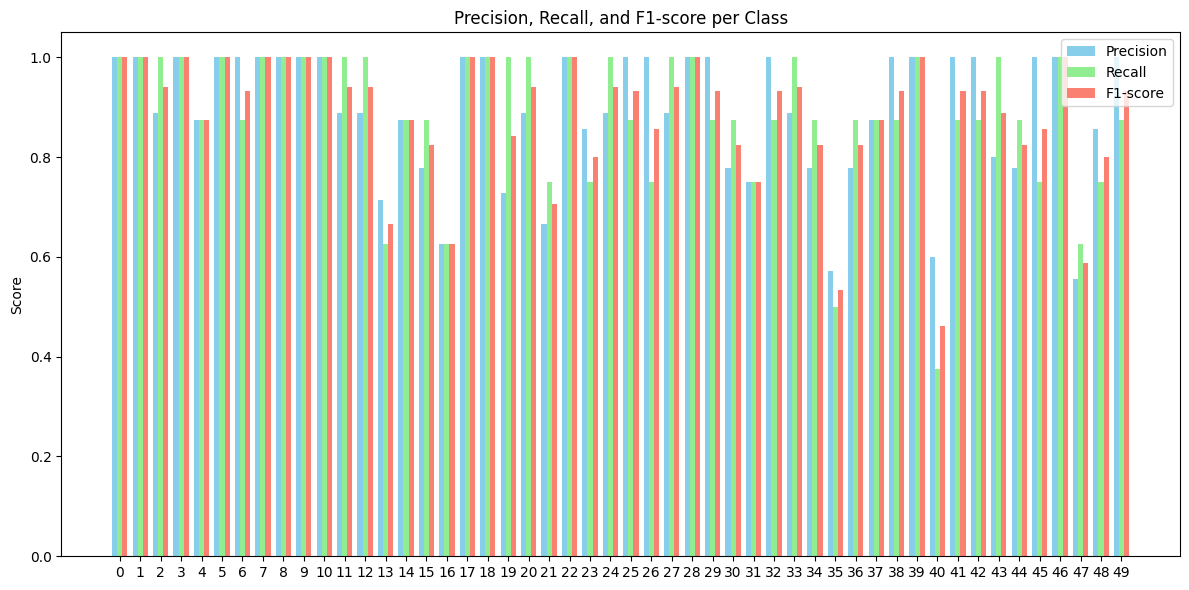

In [110]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true = []
y_pred = []

# Use your actual DataLoader for validation or test
with torch.no_grad():
    for xb, yb in test_loader:  # replace with your actual test loader
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = outputs.argmax(1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Metrics and visualization ===
report = classification_report(y_true, y_pred, output_dict=True)
labels = list(report.keys())[:-3]  # drop avg/accuracy entries

# Bar Chart
precision = [report[l]['precision'] for l in labels]
recall = [report[l]['recall'] for l in labels]
f1 = [report[l]['f1-score'] for l in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-score', color='salmon')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score per Class")
plt.legend()
plt.tight_layout()
plt.show()


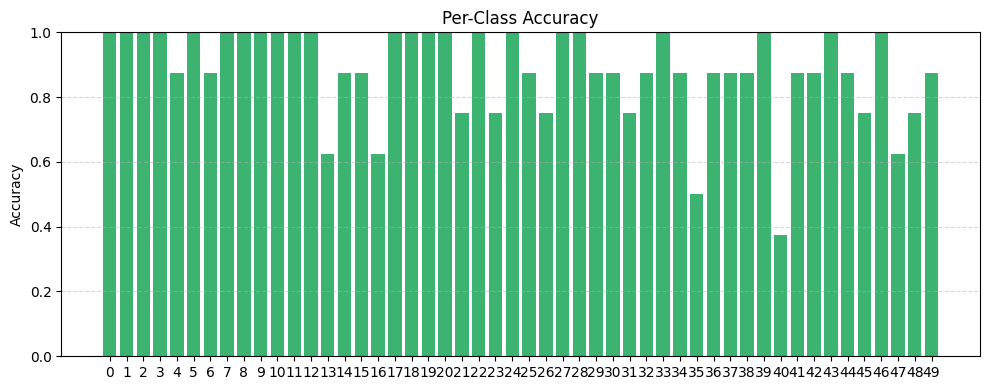

In [111]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 4))
plt.bar(labels, per_class_acc, color='mediumseagreen')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


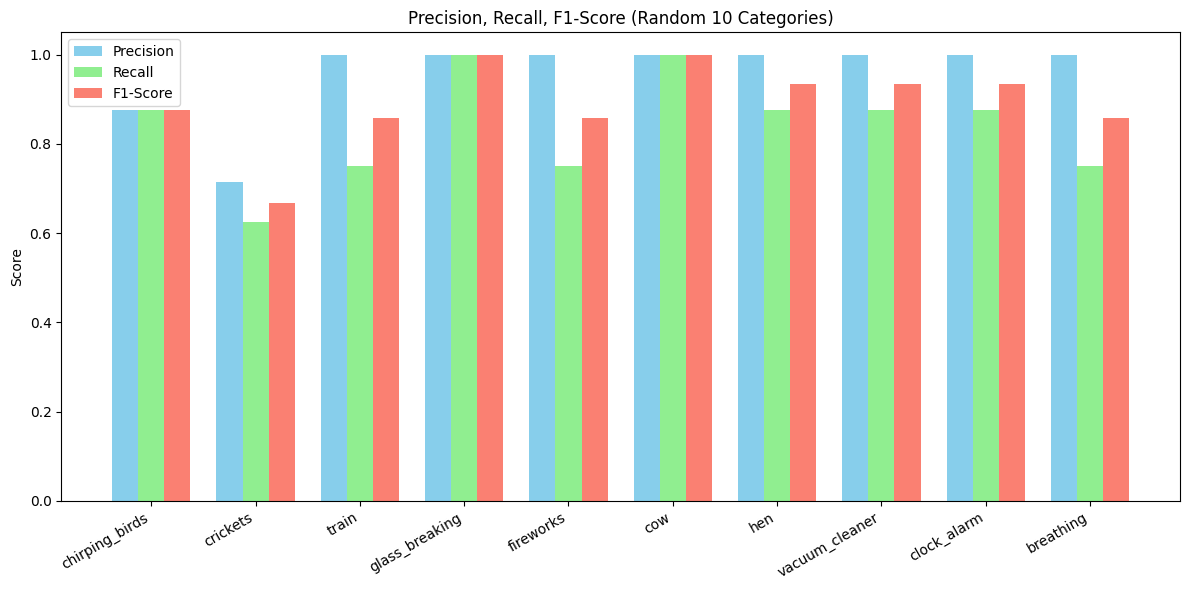

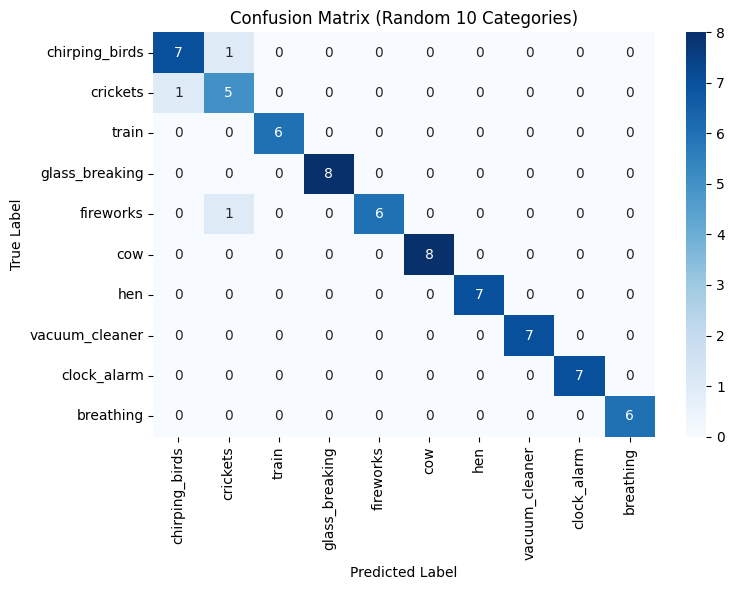

In [115]:
import random
from sklearn.metrics import classification_report, confusion_matrix

# === Step 1: Create mapping from index to original label using your DataFrame ===
index_to_label = dict(zip(df['target'], df['category']))

# === Step 2: Decode full y_true and y_pred using index_to_label ===
decoded_y_true = [index_to_label[i] for i in y_true]
decoded_y_pred = [index_to_label[i] for i in y_pred]

# === Step 3: Randomly select N categories to visualize ===
N = 10  # number of categories to visualize
selected_categories = random.sample(list(set(decoded_y_true)), N)

# === Step 4: Filter predictions and labels to only include selected categories ===
filtered_true = [yt for yt, yp in zip(decoded_y_true, decoded_y_pred) if yt in selected_categories]
filtered_pred = [yp for yt, yp in zip(decoded_y_true, decoded_y_pred) if yt in selected_categories]

# === Step 5: Classification Report ===
report = classification_report(filtered_true, filtered_pred, output_dict=True, labels=selected_categories)

# === Step 6: Bar Chart (Precision, Recall, F1-Score) ===
precision = [report[label]['precision'] for label in selected_categories]
recall = [report[label]['recall'] for label in selected_categories]
f1 = [report[label]['f1-score'] for label in selected_categories]

x = np.arange(len(selected_categories))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-Score', color='salmon')
plt.xticks(x, selected_categories, rotation=30, ha='right')
plt.ylabel('Score')
plt.title(f'Precision, Recall, F1-Score (Random {N} Categories)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 7: Confusion Matrix ===
cm = confusion_matrix(filtered_true, filtered_pred, labels=selected_categories)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=selected_categories, yticklabels=selected_categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Random {N} Categories)')
plt.tight_layout()
plt.show()
